## THIS STUDIES DATA DURING CAMPA_18 DAY 587 - 642

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn.cluster import KMeans

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [4]:
dir_path = '~/Documents/DATA_SCIENCE/Kroger_Retail_Dunnhumby/The-Complete-Journey/data/'

file1= dir_path + 'transaction_data.csv'
file2 = dir_path + 'hh_demographic.csv'
file3 = dir_path + 'coupon_redempt.csv'
file4= dir_path + 'coupon.csv'
file5 = dir_path + 'campaign_desc.csv'
file6 = dir_path + 'campaign_table.csv'
# file7= dir_path + 'causal_data.csv'
file8 = dir_path + 'product.csv'


In [5]:
def load_data(filename):
    df = pd.read_csv(filename)
    df.columns = df.columns.str.lower()
    return df
    

In [7]:
# import data into dataframe

df_trans_full = load_data(file1)
df_cus = load_data(file2)
df_coupon_redempt_full = load_data(file3)
df_coupon_full = load_data(file4)
df_camp_cus_full = load_data(file6)
# df_prod_causal = load_data(file7)
df_prod = load_data(file8)

df_campaign_detail = pd.read_csv('DATA_CLEAN/campaign_details.csv')


In [8]:
# data during campA 18 - day 587 to 642
df_trans = df_trans_full[(df_trans_full.day>=587) & (df_trans_full.day<=642)]
print('Total trans', df_trans_full.shape)
df_trans.shape

Total trans (2595732, 12)


(233860, 12)

In [14]:
# data during campA 18 - day 587 to 642
df_coupon_redempt = df_coupon_redempt_full.query('campaign==18')
print('Total trans', df_coupon_redempt_full.shape)
df_coupon_redempt.shape

Total trans (2318, 4)


(653, 4)

In [15]:
# data during campA 18 - day 587 to 642
df_coupon = df_coupon_full.query('campaign==18')
print('Total trans', df_coupon_full.shape)
df_coupon.shape


Total trans (124548, 3)


(37589, 3)

In [16]:
# data during campA 18 - day 587 to 642
df_camp_cus = df_camp_cus_full.query('campaign==18')
print('Total trans', df_camp_cus_full.shape)
df_camp_cus.shape


Total trans (7208, 3)


(1133, 3)

In [17]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [18]:
df_household = pd.DataFrame(df_trans_full.household_key.unique())
df_household.columns = ['household_key']
df_household


,household_key
0,2375
1,1364
2,1130
3,1173
4,98
...,...
2495,615
2496,1077
2497,1581
2498,1984


In [19]:
# calculate revenue

df_revenue = df_trans.groupby('household_key').sales_value.sum().reset_index()
df_revenue = df_revenue.rename(columns={'sales_value':'revenue'})
df_household = df_household.merge(df_revenue,on='household_key')
df_household

,household_key,revenue
0,2375,466.49
1,1364,182.92
2,1130,453.98
3,1173,55.90
4,98,658.15
...,...,...
2232,338,189.35
2233,615,107.45
2234,1077,495.03
2235,1581,299.99


In [20]:
# calculate recency
 
df_max_purchase = df_trans.groupby('household_key').day.max().reset_index()
df_max_purchase.columns=['household_key','max_shop_day']
df_max_purchase['recency'] = df_max_purchase.max_shop_day.max() - df_max_purchase.max_shop_day

df_household = df_household.merge(df_max_purchase[['household_key','recency']],on='household_key',how='left')
df_household

,household_key,revenue,recency
0,2375,466.49,3
1,1364,182.92,0
2,1130,453.98,0
3,1173,55.90,5
4,98,658.15,1
...,...,...,...
2232,338,189.35,1
2233,615,107.45,4
2234,1077,495.03,1
2235,1581,299.99,3


In [21]:
# calculate frequency

df_frequency = df_trans.groupby(['household_key','basket_id']).day.count().reset_index().drop(columns=['day'])
df_frequency = df_frequency.groupby('household_key').basket_id.count().reset_index()
df_frequency = df_frequency.rename(columns={'basket_id':'frequency'})

df_household = df_household.merge(df_frequency,on='household_key',how='left')
df_household


,household_key,revenue,recency,frequency
0,2375,466.49,3,17
1,1364,182.92,0,12
2,1130,453.98,0,24
3,1173,55.90,5,2
4,98,658.15,1,50
...,...,...,...,...
2232,338,189.35,1,13
2233,615,107.45,4,4
2234,1077,495.03,1,10
2235,1581,299.99,3,6


In [22]:
#clustering for Recency

kmeans = KMeans(n_clusters=4)
kmeans.fit(df_household[['recency']])
df_household['recency_cluster'] = kmeans.predict(df_household[['recency']])

df_household = order_cluster('recency_cluster', 'recency',df_household,False)
df_household.groupby('recency_cluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,155.0,42.735484,6.667500,34.0,37.0,42.0,49.0,55.0
1,212.0,24.099057,4.712050,18.0,20.0,23.0,28.0,33.0
2,442.0,10.868778,3.078854,7.0,8.0,10.0,14.0,17.0
3,1428.0,1.877451,1.866526,0.0,0.0,1.0,3.0,6.0


In [23]:
#clustering for Frequency

kmeans = KMeans(n_clusters=4)
kmeans.fit(df_household[['frequency']])
df_household['frequency_cluster'] = kmeans.predict(df_household[['frequency']])

df_household = order_cluster('frequency_cluster', 'frequency',df_household,True)
df_household.groupby('frequency_cluster')['frequency'].describe()



,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,1311.0,4.417239,2.522081,1.0,2.0,4.0,6.0,9.0
1,664.0,14.257530,3.335662,10.0,11.0,14.0,17.0,21.0
2,225.0,29.386667,5.954950,22.0,24.0,28.0,33.0,45.0
3,37.0,62.081081,19.095343,46.0,50.0,56.0,65.0,120.0


In [24]:
#clustering for Revenue

kmeans = KMeans(n_clusters=4)
kmeans.fit(df_household[['revenue']])
df_household['revenue_cluster'] = kmeans.predict(df_household[['revenue']])

df_household = order_cluster('revenue_cluster', 'revenue',df_household,True)
df_household.groupby('revenue_cluster')['revenue'].describe()


,count,mean,std,min,25%,50%,75%,max
revenue_cluster,,,,,,,,
0,1222.0,104.822831,71.191347,0.69,43.4800,93.515,162.5725,250.12
1,626.0,399.177620,100.140546,251.11,309.2375,386.555,484.6475,598.23
2,307.0,802.503518,150.569269,599.17,669.2800,777.470,908.3450,1161.16
3,82.0,1551.496463,451.504906,1183.69,1308.9825,1432.505,1628.2725,4609.19


In [25]:
df_household['rfm_score'] = df_household.recency_cluster + df_household.frequency_cluster + df_household.revenue_cluster

df_household['segment'] = 'Low-value'
df_household.loc[df_household.rfm_score > 3,'segment'] = 'Mid-value'
df_household.loc[df_household.rfm_score > 6,'segment'] = 'High-value'

df_household

,household_key,revenue,recency,frequency,recency_cluster,frequency_cluster,revenue_cluster,rfm_score,segment
0,2375,466.49,3,17,3,1,1,5,Mid-value
1,1172,596.30,2,19,3,1,1,5,Mid-value
2,2483,266.46,0,15,3,1,1,5,Mid-value
3,2305,539.85,1,10,3,1,1,5,Mid-value
4,985,288.61,3,11,3,1,1,5,Mid-value
...,...,...,...,...,...,...,...,...,...
2232,1740,1315.83,0,48,3,3,3,9,High-value
2233,1566,1993.01,1,56,3,3,3,9,High-value
2234,1453,2359.00,0,80,3,3,3,9,High-value
2235,1023,4609.19,1,51,3,3,3,9,High-value


In [26]:
cus_id_campA = df_camp_cus[df_camp_cus.campaign==18].household_key.unique()
len(cus_id_campA)
# cus_id_campA

1133

In [27]:
cus_id_all = df_household.household_key.unique()
len(cus_id_all)


2237

In [28]:
cus_id_campA_not_receive = set(cus_id_all)-(set(cus_id_campA))
len(cus_id_campA_not_receive)

# cus_id_campA_not_receive = df_household.query('received_campA_18==1').household_key.unique()
# len(cus_id_campA_not_receive)

1133

In [29]:
cus_id_campA_redeemed = df_coupon_redempt_full[df_coupon_redempt_full.campaign==18].household_key.unique()
len(cus_id_campA_redeemed)

214

In [30]:
cus_id_campA_not_redeemed = set(cus_id_campA)-(set(cus_id_campA_redeemed))
len(cus_id_campA_not_redeemed)

919

In [31]:
df_household[df_household.household_key.isin(cus_id_campA_redeemed)].revenue.describe()

count     214.000000
mean      731.231869
std       455.681796
min        57.940000
25%       436.702500
50%       624.090000
75%       904.092500
max      2641.150000
Name: revenue, dtype: float64

In [32]:
df_household[df_household.household_key.isin(cus_id_campA_not_redeemed)].revenue.describe()

count     890.000000
mean      423.353921
std       347.081852
min         2.500000
25%       171.292500
50%       328.170000
75%       587.265000
max      1970.660000
Name: revenue, dtype: float64

In [33]:
df_household[df_household.household_key.isin(cus_id_campA_not_receive)].revenue.describe()

count    1133.000000
mean      192.675525
std       260.563604
min         0.690000
25%        46.540000
50%       113.600000
75%       242.120000
max      4609.190000
Name: revenue, dtype: float64

In [34]:
df_household['received_campA_18'] = 1
df_household.loc[df_household.household_key.isin(cus_id_campA_not_receive),'received_campA_18'] = 0
df_household

,household_key,revenue,recency,frequency,recency_cluster,frequency_cluster,revenue_cluster,rfm_score,segment,received_campA_18
0,2375,466.49,3,17,3,1,1,5,Mid-value,1
1,1172,596.30,2,19,3,1,1,5,Mid-value,1
2,2483,266.46,0,15,3,1,1,5,Mid-value,1
3,2305,539.85,1,10,3,1,1,5,Mid-value,1
4,985,288.61,3,11,3,1,1,5,Mid-value,0
...,...,...,...,...,...,...,...,...,...,...
2232,1740,1315.83,0,48,3,3,3,9,High-value,1
2233,1566,1993.01,1,56,3,3,3,9,High-value,1
2234,1453,2359.00,0,80,3,3,3,9,High-value,1
2235,1023,4609.19,1,51,3,3,3,9,High-value,0


In [35]:
df_household['redeemed_campA_18'] = 0
df_household.loc[df_household.household_key.isin(cus_id_campA_redeemed),'redeemed_campA_18'] = 1
df_household

,household_key,revenue,recency,frequency,recency_cluster,frequency_cluster,revenue_cluster,rfm_score,segment,received_campA_18,redeemed_campA_18
0,2375,466.49,3,17,3,1,1,5,Mid-value,1,1
1,1172,596.30,2,19,3,1,1,5,Mid-value,1,0
2,2483,266.46,0,15,3,1,1,5,Mid-value,1,0
3,2305,539.85,1,10,3,1,1,5,Mid-value,1,1
4,985,288.61,3,11,3,1,1,5,Mid-value,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2232,1740,1315.83,0,48,3,3,3,9,High-value,1,0
2233,1566,1993.01,1,56,3,3,3,9,High-value,1,1
2234,1453,2359.00,0,80,3,3,3,9,High-value,1,1
2235,1023,4609.19,1,51,3,3,3,9,High-value,0,0


In [36]:
# Calculate total spend of each household for top 6 most-purchased product categories

product_category_list = ['GROCERY','DELI','PRODUCE','KIOSK-GAS','DRUG GM','MEAT']

for c in product_category_list:
    # print(c)
    arr_prod_id = df_prod[df_prod.department==c]['product_id']
    df_total_spend = df_trans[df_trans.product_id.isin(arr_prod_id)].groupby('household_key').sales_value.sum().reset_index()
    new_name = c + '_spend'
    df_total_spend.rename(columns={'sales_value':new_name},inplace=True)
    df_household = df_household.merge(df_total_spend,how='left',on='household_key')


In [37]:
df_household

,household_key,revenue,recency,frequency,recency_cluster,frequency_cluster,revenue_cluster,rfm_score,segment,received_campA_18,redeemed_campA_18,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,MEAT_spend
0,2375,466.49,3,17,3,1,1,5,Mid-value,1,1,173.75,NaN,65.80,NaN,62.36,68.50
1,1172,596.30,2,19,3,1,1,5,Mid-value,1,0,227.81,29.96,21.75,28.82,152.51,45.53
2,2483,266.46,0,15,3,1,1,5,Mid-value,1,0,147.57,2.65,35.39,NaN,40.89,17.03
3,2305,539.85,1,10,3,1,1,5,Mid-value,1,1,317.07,10.47,48.83,17.75,63.64,45.81
4,985,288.61,3,11,3,1,1,5,Mid-value,0,0,147.96,12.83,32.92,NaN,51.64,11.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,1740,1315.83,0,48,3,3,3,9,High-value,1,0,492.07,48.17,175.06,208.22,138.13,NaN
2233,1566,1993.01,1,56,3,3,3,9,High-value,1,1,1015.58,6.68,85.26,297.36,278.08,135.17
2234,1453,2359.00,0,80,3,3,3,9,High-value,1,1,1106.90,94.95,245.11,NaN,292.44,208.51
2235,1023,4609.19,1,51,3,3,3,9,High-value,0,0,1464.04,337.63,145.48,NaN,976.85,258.22


In [39]:
df_household.to_csv('DATA_CLEAN/households_duringCamp18.csv',index='False')

### HYPOTHESIS TESTING

In [38]:
# Null Hypothesis Dictionary
null_hypothesis = {
#     'H0': "Total spend does not increase with customer responding to campaign 18."
#     , 'H1': "Total spend does increase with customer responding to campaign 18."
    
    'H0': "Purchase frequency does not increase with customer responding to campaign 18."
    , 'H1': "Purchase frequency does increase with customer responding to campaign 18."
    
}

def print_sig(p_value, alpha):
    '''
    Inputs:
    p_value: Calculated p_value
    alpha: Confidence level
    '''
#     print(p_value,alpha)
    if p_value < alpha:
        print("Reject null hypothesis.")
        print(null_hypothesis['H1'])
    elif p_value > alpha:
        print("Fail to reject null hypothesis.")
        print(null_hypothesis['H0'])
    else:
        print("Our test is inconclusive.")

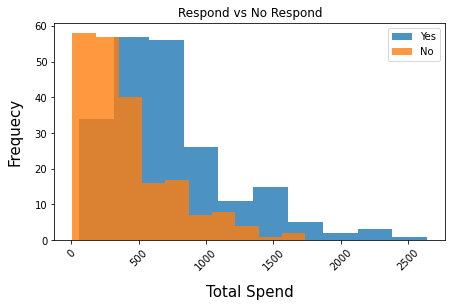

t = 8.229616027209579
p = 2.4137188333333857e-15
Reject null hypothesis.
Purchase frequency does increase with customer responding to campaign 18.


In [39]:
# Taking a sample of customers who engaged into the marketing campaigns and who did not to run hypothesis test

from scipy import stats

N = 210
camp_converted = df_household.query('received_campA_18==1 & redeemed_campA_18==1')['revenue'].sample(N,random_state=42)
camp_not_converted = df_household.query('received_campA_18==1 & redeemed_campA_18==0')['revenue'].sample(N,random_state=42)

fig = plt.figure(figsize=(7,4))
plt.hist(camp_converted,alpha=0.8)
plt.hist(camp_not_converted,alpha=0.8)
plt.xlabel('{}'.format('Total Spend'), size=15,labelpad=12.5)
plt.ylabel('Frequecy', size=15, labelpad=12.5)
plt.legend(['Yes','No'])
plt.xticks(rotation=45)
plt.title('Respond vs No Respond')
plt.show()
# fig.savefig('Yes_vs_No.png',transparent=False, bbox_inches='tight', dpi=300)

alpha = 0.05

t, p = stats.ttest_ind(camp_converted, camp_not_converted)
print("t = " + str(t))
print("p = " + str(p))
print_sig(p, alpha)

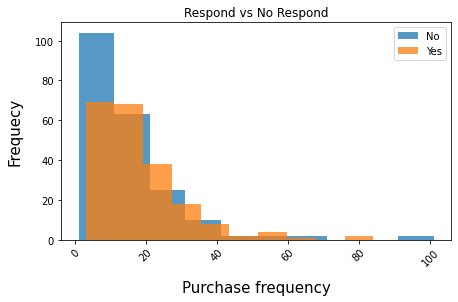

t = 3.3281555745165594
p = 0.0009516443504309445
Reject null hypothesis.
Purchase frequency does increase with customer responding to campaign 18.


In [40]:
# Taking a sample of customers who engaged into the marketing campaigns and who did not to run hypothesis test

from scipy import stats

N = 210
camp_converted = df_household.query('received_campA_18==1 & redeemed_campA_18==1')['frequency'].sample(N,random_state=42)
camp_not_converted = df_household.query('received_campA_18==1 & redeemed_campA_18==0')['frequency'].sample(N,random_state=42)

fig = plt.figure(figsize=(7,4))
plt.hist(camp_not_converted,alpha=0.75)
plt.hist(camp_converted,alpha=0.75)
plt.xlabel('{}'.format('Purchase frequency'), size=15,labelpad=12.5)
plt.ylabel('Frequecy', size=15, labelpad=12.5)
plt.legend(['No','Yes'])
plt.xticks(rotation=45)
plt.title('Respond vs No Respond')
plt.show()
# fig.savefig('Yes_vs_No.png',transparent=False, bbox_inches='tight', dpi=300)

alpha = 0.05

t, p = stats.ttest_ind(camp_converted, camp_not_converted)
print("t = " + str(t))
print("p = " + str(p))
print_sig(p, alpha)

In [41]:
# get all products promoted by campA 18

prod_id_camp18 = df_coupon.product_id.unique()

In [42]:
len(prod_id_camp18)

35513

In [12]:
df_promoted_prod_trans = df_trans[df_trans.product_id.isin(prod_id_camp18)]
df_promoted_prod_trans


,household_key,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2075143,2070,40533072090,587,8288358,1,0.89,311,0.00,28,85,0.0,0.0
2077704,1346,40544586146,587,564891,2,5.00,208,-1.98,1230,85,0.0,0.0
2077705,1346,40544586146,587,614196,1,5.49,208,-1.00,1230,85,0.0,0.0
2077708,1346,40544586146,587,687292,1,6.56,208,0.00,1230,85,0.0,0.0
2077709,1346,40544586146,587,740961,1,2.49,208,0.00,1230,85,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2314980,36,41400725537,642,5564901,1,5.49,320,-0.80,1022,92,0.0,0.0
2314981,36,41400725537,642,5587133,10,4.00,320,0.00,1022,92,0.0,0.0
2314988,77,41400727886,642,908064,1,2.00,320,-1.29,1625,92,0.0,0.0
2314989,77,41400727886,642,10457110,1,2.00,320,-1.29,1625,92,0.0,0.0


In [43]:
df_promoted_prod_trans.to_csv('DATA_CLEAN/transactions_of_campA18_products.csv',index=False)

In [43]:
cus_id_buy_promoted_prod = df_promoted_prod_trans.household_key.unique()
len(cus_id_buy_promoted_prod)

2173

In [44]:
cus_id_campA_not_receive_converted = set(cus_id_buy_promoted_prod).intersection(set(cus_id_campA_not_receive))

cus_id_campA_not_redeemed_converted = set(cus_id_buy_promoted_prod).intersection(set(cus_id_campA_not_redeemed))

cus_id_campA_redeemed_converted = set(cus_id_buy_promoted_prod).intersection(set(cus_id_campA_redeemed))

In [45]:
len(cus_id_campA_not_receive_converted)

1077

In [46]:
len(cus_id_campA_not_redeemed_converted)

882

In [47]:
len(cus_id_campA_redeemed_converted)

214

In [49]:

df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_redeemed_converted)].sales_value.sum()

71501.45999999999

### Calculate campaign 18 cost

In [68]:
total_sales_from_converted_cus = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_redeemed_converted)].sales_value.sum()
total_discount_from_converted_cus = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_redeemed_converted)].coupon_disc.sum()
total_match_discount_from_converted_cus = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_redeemed_converted)].coupon_match_disc.sum()
total_loyalty_discount_from_converted_cus = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_redeemed_converted)].retail_disc.sum()

print('Total sales from converted customers',round(total_sales_from_converted_cus,2))
print('Total coupon value discount',round(total_discount_from_converted_cus,2))
print('Total loyalty discount',round(total_loyalty_discount_from_converted_cus,2))

cost1 = abs(total_discount_from_converted_cus+total_loyalty_discount_from_converted_cus)
# ad cost of 1104 households
cost2 = 1104 * 5
cost3 = (cost1 + cost2)*0.10
total_cost = cost1 + cost2 + cost3
print('Cost - discount',cost1)
print('Cost - advertisement',cost2)
print('Cost - other',cost3)

print('Total cost',total_cost)
print('Total cost vs revenue from campaign', round(total_cost/total_sales_from_converted_cus,2))
print('ROI',round((total_sales_from_converted_cus - total_cost)/total_cost*100,2))

Total sales from converted customers 71501.46
Total coupon value discount -1163.6
Total loyalty discount -16598.52
Cost - discount 17762.12
Cost - advertisement 5520
Cost - other 2328.212
Total cost 25610.332
Total cost vs revenue from campaign 0.36
ROI 179.19


### Calculate campaign 18 revenue by marketing groups

In [70]:

a = df_promoted_prod_trans.sales_value.sum()
b = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_redeemed)].sales_value.sum()
c = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_not_redeemed)].sales_value.sum()
d = df_promoted_prod_trans[df_promoted_prod_trans.household_key.isin(cus_id_campA_not_receive)].sales_value.sum()

e = len(cus_id_campA_redeemed) / len(cus_id_all)
f = len(cus_id_campA_not_redeemed) / len(cus_id_all)
g = len(cus_id_campA_not_receive) / len(cus_id_all)

h = len(cus_id_campA_redeemed) / len(cus_id_campA_not_redeemed)
i = b / c

# print(a,b,c,d)
print(round(b/a,2), round(c/a,2), round(d/a,2))
print(round(e,2), round(f,2), round(g,2))


print('Total revenue from campaign18', round(a,2))
print('Total revenue from customers with redemption', round(b,2))
print('Total revenue from customers who did not redeem', round(c,2))
print('Total revenue from customers who did not receive offers', round(d,2))



print(f'Sale ratio of converted vs non-converted {round(i,2)}')
print(f'Household ratio of converted vs non-converted {round(h,2)}')




0.2 0.5 0.3
0.1 0.41 0.51
Total revenue from campaign18 350833.49
Total revenue from customers with redemption 71501.46
Total revenue from customers who did not redeem 174646.94
Total revenue from customers who did not receive offers 104685.09
Sale ratio of converted vs non-converted 0.41
Household ratio of converted vs non-converted 0.23


In [88]:
data = {'group':['Redeemed','Did not redeem','Did not receive offers'],
        'household_count':[len(cus_id_campA_redeemed),len(cus_id_campA_not_redeemed),len(cus_id_campA_not_receive)],
        'revenue':[b,c,d]}

revenue_df = pd.DataFrame.from_dict(data)
revenue_df

,group,household_count,revenue
0,Redeemed,214,71501.46
1,Did not redeem,919,174646.94
2,Did not receive offers,1133,104685.09


In [89]:
revenue_df['household_ratio'] = round(revenue_df.household_count / revenue_df.household_count.sum(),2)
revenue_df['revenue_ratio'] = round(revenue_df.revenue / revenue_df.revenue.sum(),2)
revenue_df

,group,household_count,revenue,household_ratio,revenue_ratio
0,Redeemed,214,71501.46,0.09,0.2
1,Did not redeem,919,174646.94,0.41,0.5
2,Did not receive offers,1133,104685.09,0.50,0.3


<BarContainer object of 3 artists>

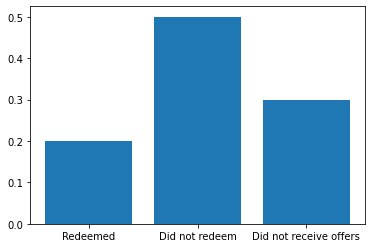

In [90]:
plt.bar(revenue_df.group, revenue_df.revenue_ratio)

<BarContainer object of 3 artists>

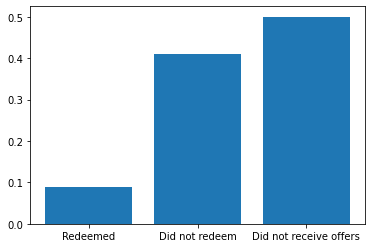

In [91]:
plt.bar(revenue_df.group, revenue_df.household_ratio)